In [1]:
import torch
import numpy as np
import pandas as pd
from scipy.special import hyp2f1
import datetime
from pathlib import Path

from models import model_selection, get_best_crit, model_evaluation
#from extreme.estimators import evt_estimators
from extreme import visualization as xviz
from extreme.data_management import DataSampler, load_quantiles, load_real_data

from rpy2 import robjects as ro
import rpy2.robjects.numpy2ri

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

# Data Description

## Load Data

In [2]:
df_real = pd.read_csv("data/real/norwegian90.csv")
df_real

,fire
0,500
1,500
2,500
3,504
4,504
...,...
623,20831
624,25509
625,26331
626,41276


## Hill Plot

\hat\gamma(k^\star=279)=0.6170444862036427


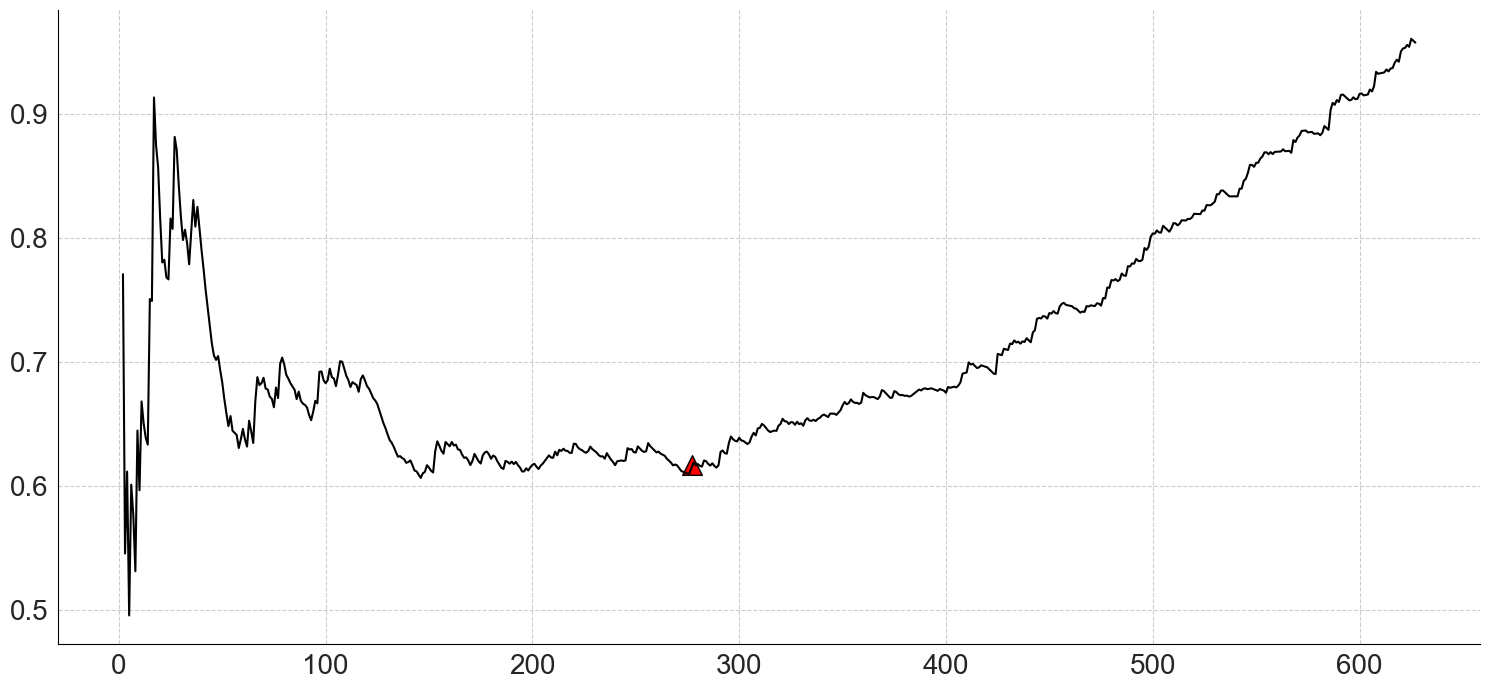

In [35]:
xviz.real_hill_plot(saved=False)

## LogLog plot

$\hat\gamma(k^\star)=$ 0.6170444862036427


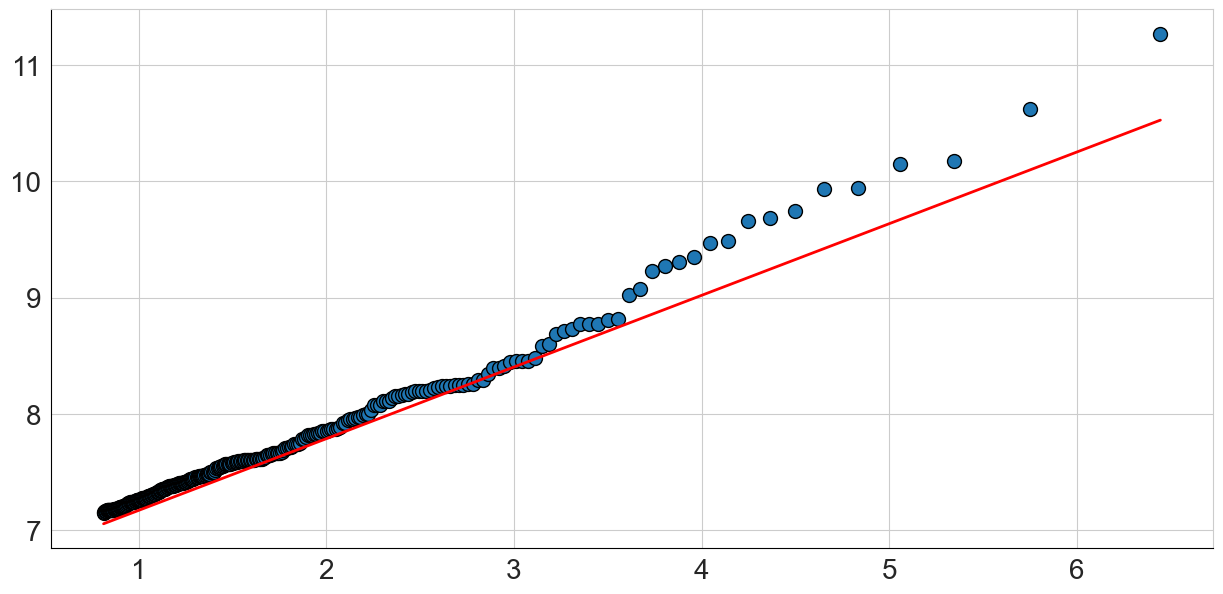

In [15]:
xviz.real_loglog_plot(percentile=1-279/df_real.shape[0], gamma_hill=0.6170444862036427, saved=True)

## Train-Test Split

\begin{align}
&\mathcal X_{\text train} = \{X_{n-i+1, n}, i=\lfloor n(1-\xi)\rfloor,\dots,n \},\\
& \mathcal X_{\text test} = \{X_{n-i+1, n}, i=1,\dots,\lceil n(1-\xi)\rceil \}
\end{align}

In [26]:
XI = 0.9
n = df_real.shape[0]
Xtrain = df_real[:int(np.floor(XI*n))]
Xtest = df_real[-int(np.ceil((1-XI)*n)):]

In [27]:
Xtrain

,fire
0,500
1,500
2,500
3,504
4,504
...,...
560,2985
561,3074
562,3210
563,3211


In [28]:
Xtest

,fire
565,3318
566,3333
567,3340
568,3404
569,3465
...,...
623,20831
624,25509
625,26331
626,41276


# BCTM Estimation

## a=0.5

167.22097683392485


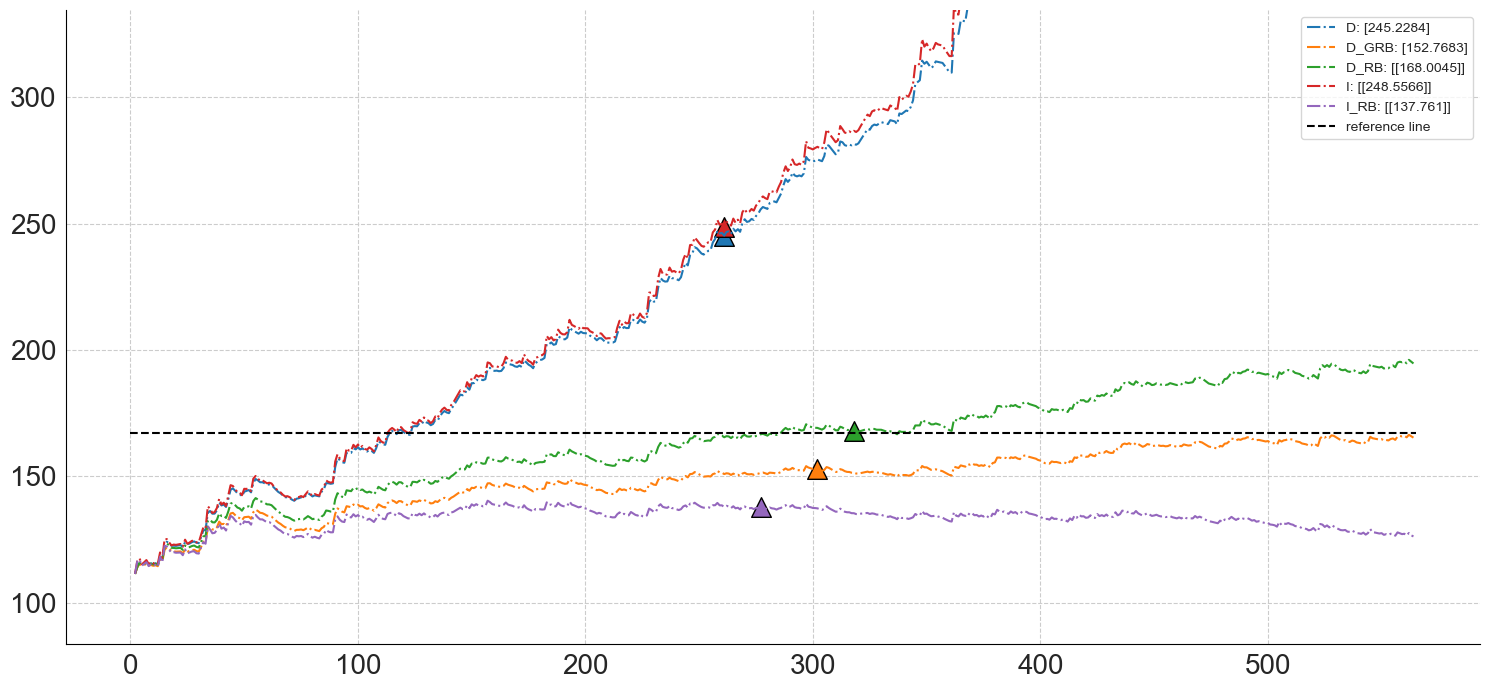

In [55]:
xviz.xes_real_bias_plot(a=0.5, xi=0.9, saved=False)

## a=1

8731.0


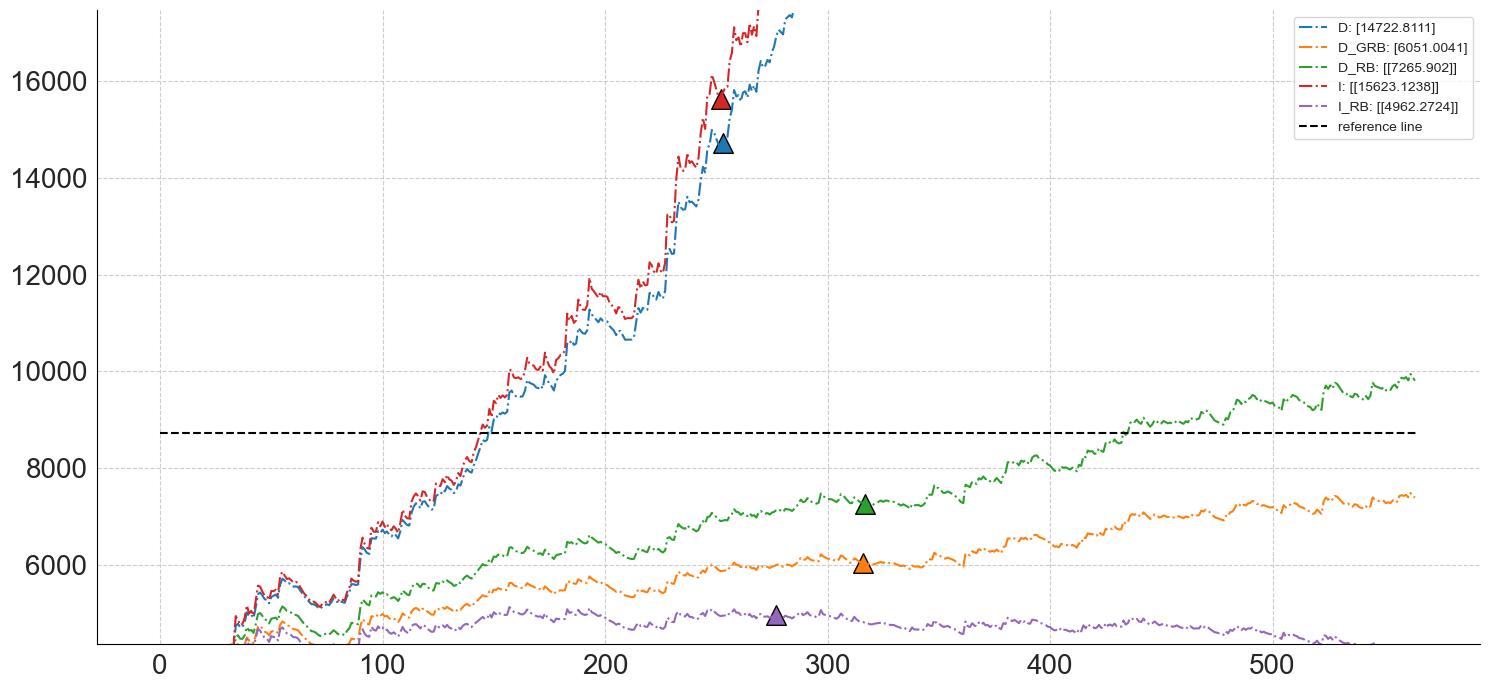

In [56]:
xviz.xes_real_bias_plot(a=1, xi=0.9, saved=False)

# Rho estimation

In [49]:
rpy2.robjects.numpy2ri.activate()
r = ro.r
r['source']('extreme/revt.R')
get_rho_beta = r.get_rho_beta

In [51]:
# train
rho, beta = get_rho_beta(np.sort(Xtrain)) 
rho, beta

(array([-0.49016798]), array([0.95079415]))

In [52]:
# test
rho, beta = get_rho_beta(np.sort(Xtest)) 
rho, beta

(array([-2.05879545]), array([-1.51441022]))

In [53]:
# full
rho, beta = get_rho_beta(np.sort(df_real)) 
rho, beta

(array([-1.84736233]), array([0.77837252]))

# CTE estimation through BCTM
\begin{align}
\label{eq:bctm:1:2}
\widehat{\rm CTE}(p_n;1/2) = \frac{1}{1-\widehat\gamma(k_n^\star)}\left( \left(1-\frac{\widehat\gamma(k_n^\star)}{2}\right)\left( 1+\frac{1}{2} \widehat{\mathcal M}_{1/2}(p_n)\right)\right)^2.
\end{align}

In [5]:
## X_train and hill
xviz.xes_real_cte_half(xi=0.9, gamma_estimator="hill")

Gamma estimation: 0.4405513802205444


{'D': array([16605.75095024]),
 'D_GRB': array([6507.67388326]),
 'D_RB': array([[7852.04576806]]),
 'I': array([[17055.85536721]]),
 'I_RB': array([[5306.81706695]]),
 'emp': 8732.0}